In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_1', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [3]:
batch_size = 64
learning_rate = 0.001

transforms = transforms.Composetransforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion4ver/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion4ver/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


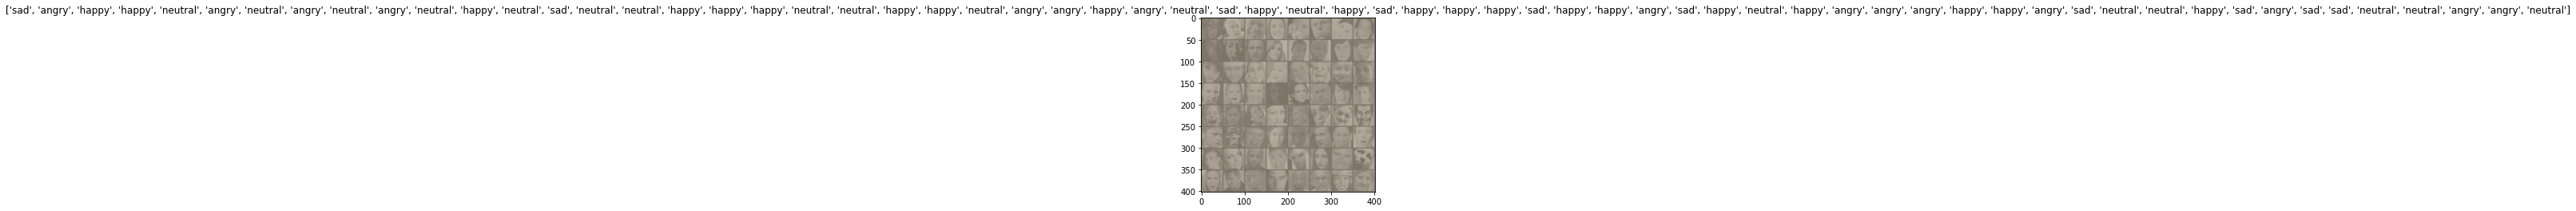

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Squeezenet1.1_lr0.001_batch64_epoch100.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/329], Loss: 6.8999
Epoch [1/100], Step [20/329], Loss: 1.4261
Epoch [1/100], Step [40/329], Loss: 1.3871
Epoch [1/100], Step [60/329], Loss: 1.3956
Epoch [1/100], Step [80/329], Loss: 1.3895
Epoch [1/100], Step [100/329], Loss: 1.4454
Epoch [1/100], Step [120/329], Loss: 1.3829
Epoch [1/100], Step [140/329], Loss: 1.4429
Epoch [1/100], Step [160/329], Loss: 1.3685
Epoch [1/100], Step [180/329], Loss: 1.3872
Epoch [1/100], Step [200/329], Loss: 1.3689
Epoch [1/100], Step [220/329], Loss: 1.3781
Epoch [1/100], Step [240/329], Loss: 1.4590
Epoch [1/100], Step [260/329], Loss: 1.3981
Epoch [1/100], Step [280/329], Loss: 1.3098
Epoch [1/100], Step [300/329], Loss: 1.4060
Epoch [1/100], Step [320/329], Loss: 1.4109

train-loss: 1.4876, train-acc: 30.8546
validation loss: 1.3618, validation acc: 34.0368

Improvement-Detected, save-model
Epoch 2

Epoch [2/100], Step [0/329], Loss: 1.3728
Epoch [2/100], Step [20/329], Loss: 1.3408
Epoch [2/100], Step [40/329], Lo

Epoch [10/100], Step [180/329], Loss: 0.9050
Epoch [10/100], Step [200/329], Loss: 0.9460
Epoch [10/100], Step [220/329], Loss: 1.0814
Epoch [10/100], Step [240/329], Loss: 0.9400
Epoch [10/100], Step [260/329], Loss: 1.0251
Epoch [10/100], Step [280/329], Loss: 0.8212
Epoch [10/100], Step [300/329], Loss: 1.1781
Epoch [10/100], Step [320/329], Loss: 1.1444

train-loss: 1.1652, train-acc: 53.9300
validation loss: 1.1435, validation acc: 53.4344

Epoch 11

Epoch [11/100], Step [0/329], Loss: 1.0718
Epoch [11/100], Step [20/329], Loss: 1.0461
Epoch [11/100], Step [40/329], Loss: 1.0117
Epoch [11/100], Step [60/329], Loss: 0.8569
Epoch [11/100], Step [80/329], Loss: 1.0559
Epoch [11/100], Step [100/329], Loss: 1.1081
Epoch [11/100], Step [120/329], Loss: 0.8468
Epoch [11/100], Step [140/329], Loss: 0.9981
Epoch [11/100], Step [160/329], Loss: 1.1197
Epoch [11/100], Step [180/329], Loss: 1.0299
Epoch [11/100], Step [200/329], Loss: 1.0060
Epoch [11/100], Step [220/329], Loss: 0.9134
Epoch 


train-loss: 1.0461, train-acc: 65.5130
validation loss: 1.0723, validation acc: 59.6124

Epoch 20

Epoch [20/100], Step [0/329], Loss: 0.9992
Epoch [20/100], Step [20/329], Loss: 0.7145
Epoch [20/100], Step [40/329], Loss: 0.6619
Epoch [20/100], Step [60/329], Loss: 0.7518
Epoch [20/100], Step [80/329], Loss: 0.6945
Epoch [20/100], Step [100/329], Loss: 0.6983
Epoch [20/100], Step [120/329], Loss: 0.8457
Epoch [20/100], Step [140/329], Loss: 0.8757
Epoch [20/100], Step [160/329], Loss: 0.7825
Epoch [20/100], Step [180/329], Loss: 0.7505
Epoch [20/100], Step [200/329], Loss: 0.8533
Epoch [20/100], Step [220/329], Loss: 0.9876
Epoch [20/100], Step [240/329], Loss: 0.7991
Epoch [20/100], Step [260/329], Loss: 0.8750
Epoch [20/100], Step [280/329], Loss: 0.5814
Epoch [20/100], Step [300/329], Loss: 0.8135
Epoch [20/100], Step [320/329], Loss: 1.0799

train-loss: 1.0343, train-acc: 66.4508
validation loss: 1.0671, validation acc: 59.2863

Epoch 21

Epoch [21/100], Step [0/329], Loss: 0.814

Epoch [29/100], Step [180/329], Loss: 0.7780
Epoch [29/100], Step [200/329], Loss: 0.4919
Epoch [29/100], Step [220/329], Loss: 0.8855
Epoch [29/100], Step [240/329], Loss: 0.6657
Epoch [29/100], Step [260/329], Loss: 0.8169
Epoch [29/100], Step [280/329], Loss: 0.7530
Epoch [29/100], Step [300/329], Loss: 0.4999
Epoch [29/100], Step [320/329], Loss: 0.6276

train-loss: 0.9389, train-acc: 74.0062
validation loss: 1.0482, validation acc: 60.0153

Epoch 30

Epoch [30/100], Step [0/329], Loss: 0.5474
Epoch [30/100], Step [20/329], Loss: 0.6221
Epoch [30/100], Step [40/329], Loss: 0.7439
Epoch [30/100], Step [60/329], Loss: 0.7471
Epoch [30/100], Step [80/329], Loss: 0.6157
Epoch [30/100], Step [100/329], Loss: 0.6046
Epoch [30/100], Step [120/329], Loss: 0.5316
Epoch [30/100], Step [140/329], Loss: 0.6628
Epoch [30/100], Step [160/329], Loss: 0.7610
Epoch [30/100], Step [180/329], Loss: 0.8517
Epoch [30/100], Step [200/329], Loss: 0.6174
Epoch [30/100], Step [220/329], Loss: 0.9135
Epoch 

Epoch [39/100], Step [20/329], Loss: 0.5470
Epoch [39/100], Step [40/329], Loss: 0.4506
Epoch [39/100], Step [60/329], Loss: 0.3882
Epoch [39/100], Step [80/329], Loss: 0.5276
Epoch [39/100], Step [100/329], Loss: 0.4633
Epoch [39/100], Step [120/329], Loss: 0.5327
Epoch [39/100], Step [140/329], Loss: 0.6244
Epoch [39/100], Step [160/329], Loss: 0.3962
Epoch [39/100], Step [180/329], Loss: 0.4588
Epoch [39/100], Step [200/329], Loss: 0.4489
Epoch [39/100], Step [220/329], Loss: 0.5249
Epoch [39/100], Step [240/329], Loss: 0.4691
Epoch [39/100], Step [260/329], Loss: 0.3706
Epoch [39/100], Step [280/329], Loss: 0.5495
Epoch [39/100], Step [300/329], Loss: 0.3754
Epoch [39/100], Step [320/329], Loss: 0.6046

train-loss: 0.8412, train-acc: 81.5520
validation loss: 1.0824, validation acc: 57.7130

Epoch 40

Epoch [40/100], Step [0/329], Loss: 0.5616
Epoch [40/100], Step [20/329], Loss: 0.3415
Epoch [40/100], Step [40/329], Loss: 0.6771
Epoch [40/100], Step [60/329], Loss: 0.4899
Epoch [40

Epoch [48/100], Step [240/329], Loss: 0.4933
Epoch [48/100], Step [260/329], Loss: 0.3607
Epoch [48/100], Step [280/329], Loss: 0.3189
Epoch [48/100], Step [300/329], Loss: 0.2763
Epoch [48/100], Step [320/329], Loss: 0.3163

train-loss: 0.7604, train-acc: 87.0650
validation loss: 1.1327, validation acc: 58.4421

Epoch 49

Epoch [49/100], Step [0/329], Loss: 0.5133
Epoch [49/100], Step [20/329], Loss: 0.4526
Epoch [49/100], Step [40/329], Loss: 0.3664
Epoch [49/100], Step [60/329], Loss: 0.4192
Epoch [49/100], Step [80/329], Loss: 0.3995
Epoch [49/100], Step [100/329], Loss: 0.3613
Epoch [49/100], Step [120/329], Loss: 0.3176
Epoch [49/100], Step [140/329], Loss: 0.4601
Epoch [49/100], Step [160/329], Loss: 0.4378
Epoch [49/100], Step [180/329], Loss: 0.2436
Epoch [49/100], Step [200/329], Loss: 0.3658
Epoch [49/100], Step [220/329], Loss: 0.4028
Epoch [49/100], Step [240/329], Loss: 0.2325
Epoch [49/100], Step [260/329], Loss: 0.4296
Epoch [49/100], Step [280/329], Loss: 0.5577
Epoch 

Epoch [58/100], Step [80/329], Loss: 0.2791
Epoch [58/100], Step [100/329], Loss: 0.2006
Epoch [58/100], Step [120/329], Loss: 0.3971
Epoch [58/100], Step [140/329], Loss: 0.2258
Epoch [58/100], Step [160/329], Loss: 0.1569
Epoch [58/100], Step [180/329], Loss: 0.1784
Epoch [58/100], Step [200/329], Loss: 0.3526
Epoch [58/100], Step [220/329], Loss: 0.1883
Epoch [58/100], Step [240/329], Loss: 0.2493
Epoch [58/100], Step [260/329], Loss: 0.2343
Epoch [58/100], Step [280/329], Loss: 0.5533
Epoch [58/100], Step [300/329], Loss: 0.3345
Epoch [58/100], Step [320/329], Loss: 0.3192

train-loss: 0.6815, train-acc: 90.3404
validation loss: 1.2129, validation acc: 59.5741

Epoch 59

Epoch [59/100], Step [0/329], Loss: 0.3118
Epoch [59/100], Step [20/329], Loss: 0.2334
Epoch [59/100], Step [40/329], Loss: 0.1985
Epoch [59/100], Step [60/329], Loss: 0.2763
Epoch [59/100], Step [80/329], Loss: 0.2838
Epoch [59/100], Step [100/329], Loss: 0.2264
Epoch [59/100], Step [120/329], Loss: 0.1366
Epoch [

Epoch [67/100], Step [300/329], Loss: 0.4075
Epoch [67/100], Step [320/329], Loss: 0.2245

train-loss: 0.6213, train-acc: 91.5925
validation loss: 1.2915, validation acc: 60.0345

Epoch 68

Epoch [68/100], Step [0/329], Loss: 0.0953
Epoch [68/100], Step [20/329], Loss: 0.1413
Epoch [68/100], Step [40/329], Loss: 0.2916
Epoch [68/100], Step [60/329], Loss: 0.0863
Epoch [68/100], Step [80/329], Loss: 0.2725
Epoch [68/100], Step [100/329], Loss: 0.0885
Epoch [68/100], Step [120/329], Loss: 0.1675
Epoch [68/100], Step [140/329], Loss: 0.1635
Epoch [68/100], Step [160/329], Loss: 0.3037
Epoch [68/100], Step [180/329], Loss: 0.4342
Epoch [68/100], Step [200/329], Loss: 0.2792
Epoch [68/100], Step [220/329], Loss: 0.1260
Epoch [68/100], Step [240/329], Loss: 0.0533
Epoch [68/100], Step [260/329], Loss: 0.2225
Epoch [68/100], Step [280/329], Loss: 0.2273
Epoch [68/100], Step [300/329], Loss: 0.1129
Epoch [68/100], Step [320/329], Loss: 0.1707

train-loss: 0.6151, train-acc: 93.0207
validation 

Epoch [77/100], Step [140/329], Loss: 0.2773
Epoch [77/100], Step [160/329], Loss: 0.1924
Epoch [77/100], Step [180/329], Loss: 0.0443
Epoch [77/100], Step [200/329], Loss: 0.2461
Epoch [77/100], Step [220/329], Loss: 0.1355
Epoch [77/100], Step [240/329], Loss: 0.0773
Epoch [77/100], Step [260/329], Loss: 0.1211
Epoch [77/100], Step [280/329], Loss: 0.2264
Epoch [77/100], Step [300/329], Loss: 0.2582
Epoch [77/100], Step [320/329], Loss: 0.2539

train-loss: 0.5647, train-acc: 93.4444
validation loss: 1.3791, validation acc: 58.1926

Epoch 78

Epoch [78/100], Step [0/329], Loss: 0.1461
Epoch [78/100], Step [20/329], Loss: 0.0638
Epoch [78/100], Step [40/329], Loss: 0.1301
Epoch [78/100], Step [60/329], Loss: 0.1210
Epoch [78/100], Step [80/329], Loss: 0.1631
Epoch [78/100], Step [100/329], Loss: 0.1223
Epoch [78/100], Step [120/329], Loss: 0.1434
Epoch [78/100], Step [140/329], Loss: 0.1783
Epoch [78/100], Step [160/329], Loss: 0.1139
Epoch [78/100], Step [180/329], Loss: 0.2724
Epoch 

validation loss: 1.4548, validation acc: 57.5979

Epoch 87

Epoch [87/100], Step [0/329], Loss: 0.2886
Epoch [87/100], Step [20/329], Loss: 0.0712
Epoch [87/100], Step [40/329], Loss: 0.1119
Epoch [87/100], Step [60/329], Loss: 0.0591
Epoch [87/100], Step [80/329], Loss: 0.1691
Epoch [87/100], Step [100/329], Loss: 0.1118
Epoch [87/100], Step [120/329], Loss: 0.2169
Epoch [87/100], Step [140/329], Loss: 0.1439
Epoch [87/100], Step [160/329], Loss: 0.0889
Epoch [87/100], Step [180/329], Loss: 0.1812
Epoch [87/100], Step [200/329], Loss: 0.2041
Epoch [87/100], Step [220/329], Loss: 0.1434
Epoch [87/100], Step [240/329], Loss: 0.1176
Epoch [87/100], Step [260/329], Loss: 0.2221
Epoch [87/100], Step [280/329], Loss: 0.1427
Epoch [87/100], Step [300/329], Loss: 0.2883
Epoch [87/100], Step [320/329], Loss: 0.2466

train-loss: 0.5185, train-acc: 94.8298
validation loss: 1.4617, validation acc: 59.1520

Epoch 88

Epoch [88/100], Step [0/329], Loss: 0.1193
Epoch [88/100], Step [20/329], Loss: 0

Epoch [96/100], Step [200/329], Loss: 0.1331
Epoch [96/100], Step [220/329], Loss: 0.1153
Epoch [96/100], Step [240/329], Loss: 0.1572
Epoch [96/100], Step [260/329], Loss: 0.0958
Epoch [96/100], Step [280/329], Loss: 0.0823
Epoch [96/100], Step [300/329], Loss: 0.0784
Epoch [96/100], Step [320/329], Loss: 0.0251

train-loss: 0.4830, train-acc: 95.5772
validation loss: 1.5312, validation acc: 60.0921

Epoch 97

Epoch [97/100], Step [0/329], Loss: 0.0558
Epoch [97/100], Step [20/329], Loss: 0.1602
Epoch [97/100], Step [40/329], Loss: 0.2286
Epoch [97/100], Step [60/329], Loss: 0.2325
Epoch [97/100], Step [80/329], Loss: 0.0896
Epoch [97/100], Step [100/329], Loss: 0.0127
Epoch [97/100], Step [120/329], Loss: 0.1616
Epoch [97/100], Step [140/329], Loss: 0.0961
Epoch [97/100], Step [160/329], Loss: 0.1272
Epoch [97/100], Step [180/329], Loss: 0.1141
Epoch [97/100], Step [200/329], Loss: 0.1182
Epoch [97/100], Step [220/329], Loss: 0.0871
Epoch [97/100], Step [240/329], Loss: 0.0435
Epoch 

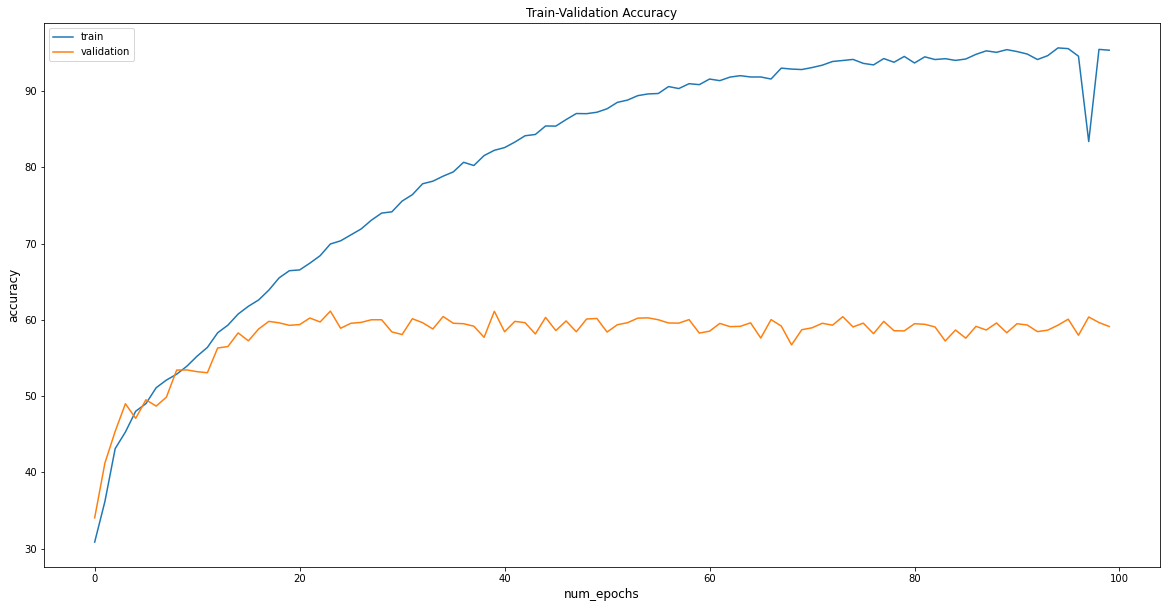

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

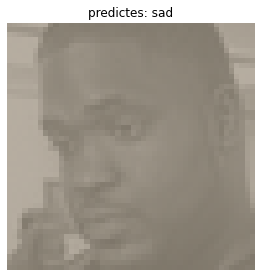

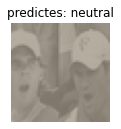

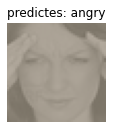

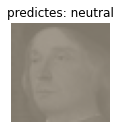

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()